## Complementarity & Accessibilty

### 1.  Imports & Declarations

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import requests
%matplotlib inline
# from pydantic_settings import BaseSettings
from ydata_profiling import ProfileReport

import sys
sys.path.append('../utils/')
from functions import get_zone_info

In [46]:
#######################################################################################################################################
# GREEN MOBILITY
#######################################################################################################################################

# Initialize dataframe
file_path = "../data/processed/gm_raw.csv"
gm_source = pd.read_csv(file_path)

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.

# Add columns if necessary

#######################################################################################################################################
# DRIVE NOW
#######################################################################################################################################

# 1. Initialize dataframe
file_path = "../data/raw/DriveNow/DTU - data til case_LTMZones1.csv"
sn_source = pd.read_csv(file_path, sep=";")

# 2. Rename columns if necessary
sn_source.rename(columns= {
                            "Latitude (Start)": "LatitudeStart", 
                            "Longitude (Start)": "LongitudeStart", 
                            'Latitude (Slut)': "LatitudeEnd", 
                            'Longitude (Slut)':'LongitudeEnd',
                            'Reservationstidspunkt': "ReservationTime",
                            'Start tidspunkt': "StartTime",
                            'Slut tidspunkt': "EndTime",
                            'Alder': "Age",
                            'Køn': "Gender",
                            'Batteristatus (start)': "BatteryStart",
                            'Batteristatus (slut)':"BatteryEnd",
                            'Km kørt': "KmDriven"
                            }, inplace=True)

# 3. Drop columns if necessary
sn_source.drop(columns=['TurID'],inplace=True)

# 4. Convert to appropriate data types
sn_source['KmDriven'] = pd.to_numeric(sn_source['KmDriven'], errors='coerce')   #   to Numeric
sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime
sn_source['BatteryStart'] = pd.to_numeric(sn_source['BatteryStart'], errors = 'coerce') #   to numeric
sn_source['BatteryEnd'] = pd.to_numeric(sn_source['BatteryEnd'], errors = 'coerce') #   to numeric

# 5. Auxiliary columns
sn_source['TripDurationHours'] = (sn_source['EndTime'] - sn_source['StartTime']).dt.total_seconds()/3600
sn_source['TripDurationMinutes'] = sn_source['TripDurationHours']*60  #   trip duration in min
sn_source['AvgSpeed'] = sn_source['KmDriven']/sn_source['TripDurationHours'] #   avg speed

sn_source['Month'] = sn_source['StartTime'].dt.strftime("%B").astype('category')  #   month
sn_source['Weekday'] = sn_source['StartTime'].dt.day_name().astype('category')    #   day of the week
sn_source['StartHour'] = sn_source['StartTime'].dt.hour.astype('category')    #   hour of the day

# 6. Descriptive statistics
sn_source.describe()

# 7. Drop outliers, missing values, etc.

# drop rows with missing values
sn_source.dropna(inplace=True)

# drop rows with negative and avg speed > 100 km/h
sn_source = sn_source[(sn_source['AvgSpeed'] > 0) & (sn_source['AvgSpeed'] < 100)]

#################################################################################################################################
# DONKEY REPUBLIC
#################################################################################################################################


# Initialize Donkey Republic dataframe
file_path = ""
donkey_source = ""

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.

/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_98942/3250727588.py:25: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  sn_source = pd.read_csv(file_path, sep=";")
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_98942/3250727588.py:48: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_98942/3250727588.py:49: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


In [24]:
# ProfileReport(sn_source, title="DriveNow", explorative=True)
def get_osrm_route_distance(start_lat, start_lon, end_lat, end_lon):
    route_service_url = f"http://router.project-osrm.org/route/v1/driving/{start_lon},{start_lat};{end_lon},{end_lat}?overview=false"
    response = requests.get(route_service_url)
    # Check if the response was successful
    if response.status_code != 200:
        return None
    routes = response.json().get('routes')
    if routes:
        return routes[0]['distance'] / 1000.0  # convert to km
    

_ = sn_source

print(get_osrm_route_distance(_['LatitudeStart'].iloc[0], _['LongitudeStart'].iloc[0], _['LatitudeEnd'].iloc[0], _['LongitudeEnd'].iloc[0]))



None


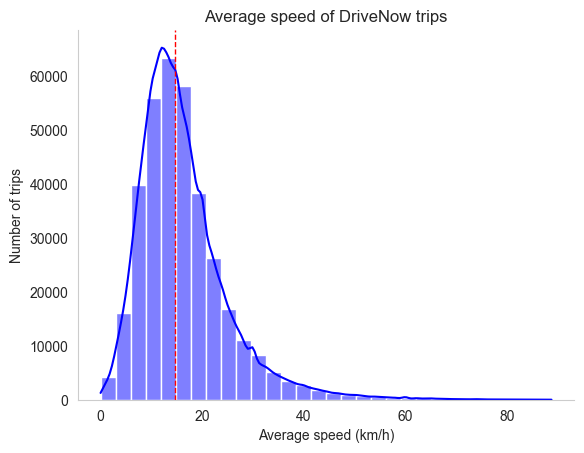

In [54]:
# plot histogram of average speed between 0 and 90 km/h using seaborn 
sns.histplot(data=sn_source[(sn_source['AvgSpeed']>0) & (sn_source['AvgSpeed']<90)], x="AvgSpeed", bins=30, color='blue', kde=True)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')

sns.despine()

# add title and labels
plt.title("Average speed of DriveNow trips")
plt.xlabel("Average speed (km/h)")
plt.ylabel("Number of trips")
plt.grid(False)
# plt.show()

# show median on the plot
plt.axvline(x=sn_source['AvgSpeed'].median(), color='red', linestyle='--', linewidth=1)
plt.show()

### 2.  Trips profiling and statistics

#### 2.1 GreenMobility Dataset

In [55]:
sn_source[(sn_source['BatteryStart']<0)]

,BilID,PersonID,LatitudeStart,LongitudeStart,LatitudeEnd,LongitudeEnd,ReservationTime,StartTime,EndTime,Age,...,BatteryEnd,KmDriven,FromZoneID,ToZoneID,TripDurationHours,TripDurationMinutes,AvgSpeed,Month,Weekday,StartHour
1564,WBY1Z21080V307860,38242,"55,669166","12,611288","55,682075","12,517583",02/08/2017 15:57,2017-08-02 15:48:00,2017-08-02 16:44:00,45,...,55.0,9,103162,147233,0.933333,56.0,9.642857,August,Wednesday,15
1887,WBY1Z21000V307805,43839,"55,698831","12,552566","55,705814","12,531183",02/08/2017 20:53,2017-08-02 20:52:00,2017-08-02 20:58:00,25,...,55.0,2,102431,102543,0.100000,6.0,20.000000,August,Wednesday,20
7718,WBY1Z210X0V307732,27172,"55,691523","12,538755","55,681273","12,523071",08/08/2017 10:40,2017-08-08 10:33:00,2017-08-08 11:24:00,35,...,15.0,14,102455,147152,0.850000,51.0,16.470588,August,Tuesday,10
9060,WBY1Z21070V308028,19032,"55,692763","12,61041","55,692564","12,540894",09/08/2017 19:24,2017-08-09 19:23:00,2017-08-09 20:43:00,32,...,41.0,16,103112,102454,1.333333,80.0,12.000000,August,Wednesday,19
9238,WBY1Z21010V308137,29894,"55,632361","12,57799","55,683066","12,615395",09/08/2017 23:32,2017-08-09 23:29:00,2017-08-09 23:45:00,25,...,63.0,7,103291,103111,0.266667,16.0,26.250000,August,Wednesday,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339206,WBY1Z21010V308249,3222,"55,697744","12,512958","55,688964","12,524793",21/04/2018 16:38,2018-04-21 16:24:00,2018-04-21 16:49:00,55,...,88.0,4,102552,147213,0.416667,25.0,9.600000,April,Saturday,16
340621,WBY1Z21080V307910,50724,"55,70718","12,541091","55,705271","12,547452",22/04/2018 14:51,2018-04-22 14:37:00,2018-04-22 15:15:00,22,...,57.0,14,102532,102433,0.633333,38.0,22.105263,April,Sunday,14
340866,WBY1Z21060V308103,7035,"55,593862","12,638786","55,670977","12,529499",22/04/2018 17:20,2018-04-22 17:05:00,2018-04-22 18:05:00,52,...,13.0,26,155018,147141,1.000000,60.0,26.000000,April,Sunday,17
356694,WBY1Z21010V307828,52619,"55,669923","12,555809","55,669666","12,554932",02/05/2018 17:57,2018-05-02 17:38:00,2018-05-02 18:15:00,38,...,91.0,6,102811,102811,0.616667,37.0,9.729730,May,Wednesday,17


/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_88003/1427624344.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(gm_data['HaversineDistance'], bins=100, color='blue', palette='Blues_r', kde=True)


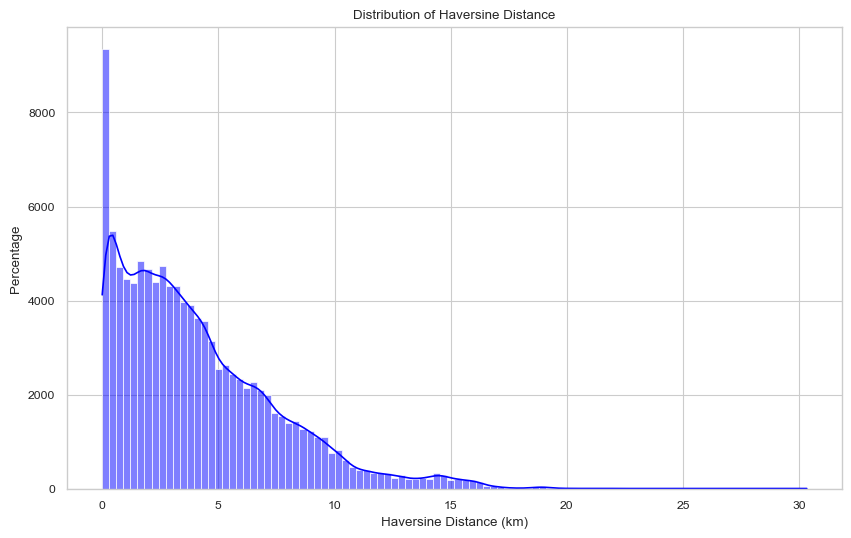

In [ ]:
# distribution of haversine distance visuzaliations
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.set_palette('Blues_r')
sns.despine()
sns.histplot(gm_data['HaversineDistance'], bins=100, color='blue', palette='Blues_r', kde=True)
plt.ylabel('Percentage')
# plt.yticks(np.arange(0, 0.06, 0.01))
# plt.gca().yaxis.set_major_formatter('{:.0f}%'.format)
plt.xlabel('Haversine Distance (km)')
plt.title('Distribution of Haversine Distance')
# plt.savefig('../reports/figures/haversine_distance.png')
plt.show()

In [ ]:
# Generate the profile report
profile = ProfileReport(sn_source, title='Pandas Profiling Report', explorative=True)

# Or to view it in a Jupyter Notebook
profile.to_notebook_iframe()


## STATISTICAL ANALYSIS : Hypothesis testing